In [15]:
# n particles. each particle has a velocity, a mass, and an acceleration
# calculate total force via a summing principle
# need to calculate v_x, v_y, v_z and a_x, a_y, a_z
# need to save positions of all particles in an velocity = [x,y,z] array
# so first create a way to take input for number of particles and randomize intial positions and velocities within a certain range
# we want to create an object of the particle. the particle will have a position (x,y,z), velocity (vx, vy, vz), acceleration (ax, ay, az) 
# calculate force from each particle by mass times acceleration on each particle in x,y, z direction. just sum up the total from the other particles to put that onto the particle
# so calculate force on each particle. create a loop and plug into newton's equations
# let's start 1000 timesteps and save all the particles. i'll save an array for each particle
# and then I will plot the total array for all particles. so i'll loop and access each of the elements of the arrays in the dth section.
# we'll stride appropriate and use a library to craft a video

In [16]:
# N-body (10 particles) — notebook cell
# - Random init with seed
# - Prints initial values
# - Velocity-Verlet integration
# - Saves video to MP4 (fallback to GIF)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import pandas as pd

# -------- Particle (no @dataclass) and Simulator ----------
class Particle:
    def __init__(self, mass, position, velocity, acceleration=None):
        self.mass = float(mass)
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.acceleration = np.zeros(3, dtype=float) if acceleration is None else np.array(acceleration, dtype=float)

class NBodySim:
    def __init__(self, particles, G=1.0, softening=1e-2):
        self.particles = particles
        self.n = len(particles)
        self.G = G
        self.eps = softening
        self.m = np.array([p.mass for p in particles])
        self.x = np.stack([p.position for p in particles])
        self.v = np.stack([p.velocity for p in particles])
        self.a = np.stack([p.acceleration for p in particles])

    def _compute_accelerations(self):
        dx = self.x[:, None, :] - self.x[None, :, :]
        r2 = np.sum(dx*dx, axis=2) + self.eps**2
        inv_r3 = np.where(r2 > 0, 1.0/np.sqrt(r2*r2*r2), 0.0)
        np.fill_diagonal(inv_r3, 0.0)
        a = self.G * (dx * (self.m[None, :] * inv_r3)[:, :, None]).sum(axis=1)
        a /= self.m[:, None]
        self.a = a

    def step(self, dt):
        v_half = self.v + 0.5*dt*self.a
        self.x = self.x + dt*v_half
        self._compute_accelerations()
        self.v = v_half + 0.5*dt*self.a

    def simulate(self, steps=600, dt=1e-2, stride=1):
        self._compute_accelerations()
        frames = steps // stride + 1
        traj = np.empty((frames, self.n, 3), dtype=float)
        traj[0] = self.x
        f = 1
        for t in range(steps):
            self.step(dt)
            if (t + 1) % stride == 0:
                traj[f] = self.x
                f += 1
        for i, p in enumerate(self.particles):
            p.position, p.velocity, p.acceleration = self.x[i], self.v[i], self.a[i]
        return traj

def random_system(n, pos_range=1.0, vel_range=0.15, mass_range=(0.9, 1.1), seed=11):
    rng = np.random.default_rng(seed)
    particles = []
    for _ in range(n):
        m = rng.uniform(*mass_range)
        x = rng.uniform(-pos_range, pos_range, size=3)
        v = rng.uniform(-vel_range, vel_range, size=3)
        particles.append(Particle(m, x, v))
    return particles

# -------- Parameters for 10 particles ----------
n = 10
steps = 600          # ~20s at 30 fps
dt = 1e-2
stride = 1
seed = 11
pos_range = 1.0
vel_range = 0.15
mass_range = (0.9, 1.1)
G = 1.0
softening = 1e-2

# -------- Initialize & print initial values ----------
particles = random_system(n, pos_range=pos_range, vel_range=vel_range,
                          mass_range=mass_range, seed=seed)

init_df = pd.DataFrame({
    "mass": [p.mass for p in particles],
    "x": [p.position[0] for p in particles],
    "y": [p.position[1] for p in particles],
    "z": [p.position[2] for p in particles],
    "vx": [p.velocity[0] for p in particles],
    "vy": [p.velocity[1] for p in particles],
    "vz": [p.velocity[2] for p in particles],
})
print("=== Initial Values for 10 particles ===")
print(init_df.to_string(index=False))

# -------- Simulate ----------
sim = NBodySim(particles, G=G, softening=softening)
traj = sim.simulate(steps=steps, dt=dt, stride=stride)  # (frames, n, 3)

# -------- Animate & Save ----------
frames = traj.shape[0]
xyz_max = float(np.abs(traj).max() * 1.1) if frames > 0 else 1.0

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(traj[0,:,0], traj[0,:,1], traj[0,:,2], s=25)
ax.set_xlim(-xyz_max, xyz_max); ax.set_ylim(-xyz_max, xyz_max); ax.set_zlim(-xyz_max, xyz_max)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title("N-body (10 particles)")

def update(i):
    scat._offsets3d = (traj[i,:,0], traj[i,:,1], traj[i,:,2])
    ax.set_title(f"N-body (10) — frame {i}/{frames-1}")
    return scat,

anim = FuncAnimation(fig, update, frames=frames, interval=33, blit=False)

# Save MP4, fallback to GIF
out_mp4 = "nbody_10_particles.mp4"
out_gif = "nbody_10_particles.gif"
try:
    writer = FFMpegWriter(fps=30, metadata={'artist': 'N-body Notebook'})
    anim.save(out_mp4, writer=writer, dpi=120)
    print(f"Saved MP4: {out_mp4}")
except Exception as e:
    writer = PillowWriter(fps=15)
    anim.save(out_gif, writer=writer, dpi=100)
    print(f"FFmpeg unavailable, saved GIF instead: {out_gif}")

plt.close(fig)

=== Initial Values for 10 particles ===
    mass         x         y         z        vx        vy        vz
0.925714 -0.001444  0.202997 -0.942622 -0.105622  0.128463 -0.128874
0.925955  0.896657  0.243767 -0.262014  0.003417  0.048853 -0.067407
0.927594  0.576079  0.340721  0.024765  0.095021  0.014723  0.144274
0.940902  0.107461 -0.032751 -0.293450  0.027479 -0.079410  0.090661
1.073467 -0.742481 -0.065854 -0.445710 -0.125065  0.118783 -0.021015
0.929538  0.346725 -0.595568  0.802862 -0.084856 -0.140078 -0.089769
0.969150 -0.062184  0.812269  0.394722 -0.048204 -0.144937 -0.102053
1.099287 -0.080568  0.382080 -0.890664 -0.139785  0.103767  0.026365
0.961742 -0.365247 -0.821525 -0.654661 -0.142624  0.101737 -0.010109
0.925441  0.478494 -0.608694 -0.876160  0.029518  0.118727 -0.141917
FFmpeg unavailable, saved GIF instead: nbody_10_particles.gif


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

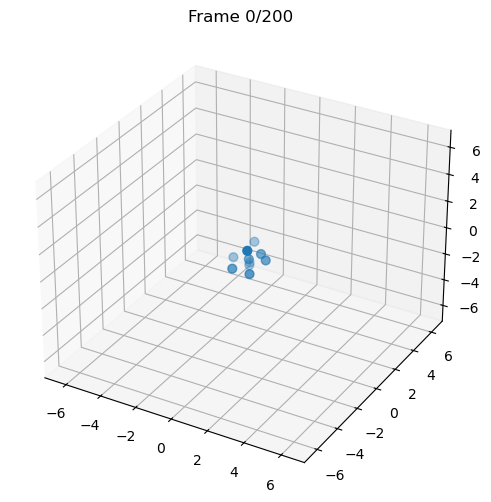